# Analysis of Contact Tracing Applications

In [1]:
import re
from datetime import date, timedelta, datetime

import pandas as pd
import numpy as np
import scipy.stats as sps
# import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import chart_studio as cs
import chart_studio.plotly as py

from tracking import config, utils

from IPython.display import display

%load_ext autoreload
%autoreload 2

In [2]:
pio.templates.default = "plotly_white"

In [3]:
sns.set(style='whitegrid', font_scale=1.5)

## Loading data

In [4]:
df_apps = pd.read_csv(config.data / 'all-apps.csv')
df_scores = pd.read_csv(config.data / 'apps_scored.csv')

In [5]:
utils.display_all(df_apps.head())

name    country                                              links  \
0     CAuDHT        NaN              https://bit.ly/blecontacttracerdesign   
1   Guardian        NaN                       https://www.myguardian.life/   
2       Hi5X        NaN                               https://hi5x-app.com   
3   NinjaPad        NaN         https://github.com/dantam/ninja-pad-python   
4  COVIDSafe  Australia  https://www.health.gov.au/resources/apps-and-t...   

     platform      data_type bluetooth  gps qr_code centralized  \
0  mobile app      bluetooth       yes   no      no         NaN   
1  mobile app            gps        no  yes      no         NaN   
2  mobile app  gps + QR code       yes  yes      no         NaN   
3  mobile app            gps        no  yes      no          no   
4  mobile app      bluetooth       yes   no      no         yes   

  centralized_storage central_id_storage central_contact_storage  \
0                 NaN                NaN                     NaN   
1                 NaN                NaN                     NaN   
2                 NaN                NaN                     NaN   
3                  no                 no                      no   
4                 yes                yes                      no   

  central_matching collect_pii       status date_proposed date_dev  \
0              NaN         NaN     proposal           NaN      NaN   
1              NaN         yes  development           NaN      NaN   
2              NaN         NaN     released           NaN      NaN   
3              NaN         NaN     proposed    2020-03-20      NaN   
4              yes         yes     released    2020-04-14      NaN   

  date_released date_cancelled          linkage_method   protocol  \
0           NaN     2020-04-18                     NaN        NaN   
1           NaN            NaN                     NaN        NaN   
2    2020-04-17            NaN                     NaN        NaN   
3           NaN     2020-04-22                     NaN        NaN   
4    2020-04-26            NaN  exchange temporary ids  BlueTrace   

    anon_method data_persistence_days government contact_trace_aid  \
0           NaN                   NaN        NaN               NaN   
1           NaN                   NaN         no               yes   
2           NaN                   NaN        NaN               NaN   
3           NaN                   NaN         no               yes   
4  pseudonymous                    21        yes               yes   

  opt_in_download opt_in_share quarantine_enforcement open_source encryption  \
0             NaN          NaN                     no         NaN        NaN   
1             yes          NaN                     no          no        NaN   
2             NaN          NaN                     no         NaN        NaN   
3             yes          yes                     no         yes        NaN   
4             yes          yes                     no         yes        yes   

  covid_positive_verification  ios_downloads  android_downloads  \
0                         NaN            NaN                NaN   
1                         NaN            NaN                NaN   
2                         NaN            NaN                NaN   
3                        test            NaN                NaN   
4                        test            NaN          1778000.0   

                      notes  
0         Merged with Safe2  
1                       NaN  
2                       NaN  
3  seems to be discontinued  
4    based on TraceTogether

In [6]:
utils.display_all(df_scores.head())

Name    Country                                              Links  \
0          Hi5X    unknown                               https://hi5x-app.com   
1     COVIDSafe  Australia  https://www.health.gov.au/resources/apps-and-t...   
2  Stopp Corona    Austria  https://www.roteskreuz.at/site/faq-app-stopp-c...   
3       BeAware    Bahrain  https://play.google.com/store/apps/details?id=...   
4  Covid Radius    Belgium  https://www.usine-digitale.fr/article/covid-19...   

  1.1. App has defined lifetime 1.2. Data storage is time-limited  \
0                       unknown                           21 days   
1                           yes                           21 days   
2                           yes                           14 days   
3                            no                                no   
4                            no                           14 days   

  2.1. Opt-in download and use 2.2. Opt-in data sharing  \
0                          yes                  unknown   
1                          yes                      yes   
2                          yes                      yes   
3                           no                       no   
4                           no                       no   

  2.3. Not tied to other benefits  \
0                         unknown   
1                             yes   
2                             yes   
3                              no   
4                              no   

  3.1. Data used only for establishing contacts 3.2. No PII collection  \
0                                       unknown                unknown   
1                                           yes                     no   
2                                           yes                    yes   
3                                            no                     no   
4                                           yes                     no   

  4.1. Open source 4.2. Published privacy policy 5.1. Freely available  \
0               no                            no                   yes   
1              yes                           yes                   yes   
2              yes                           yes                   yes   
3               no                            no                   yes   
4               no                            no                    no   

  5.2. Android and iOS (when necessary) 6.1. Decentralized storage  \
0                                  both                    unknown   
1                                  both                         no   
2                          android only                        yes   
3                          android only                         no   
4                                    no                         no   

  6.2. Can erase data 7.1. Decentralized matching  \
0             unknown                     unknown   
1                 yes                          no   
2                 yes                         yes   
3                  no                          no   
4                  no                          no   

  7.2. Rotating randomized beacon  \
0                         unknown   
1                             yes   
2                             yes   
3                              no   
4                              no   

  8.1. Contact accuracy (BLE, not GPS or other)  \
0                                 gps + qr code   
1                                           ble   
2                                           ble   
3                               gps + ebracelet   
4                                            no   

  8.2. Positive cases verified by test      protocol  
0                              unknown          none  
1                                  yes          none  
2                     no (self-report)  Apple/Google  
3                                  yes          none  
4                              unknown          none

In [7]:
df_merged = pd.merge(
    df_scores,
    df_apps[['name', 'platform', 'status', 'date_proposed', 'date_dev',
             'date_released', 'date_cancelled', 'government']],
    how='left',
    left_on='Name',
    right_on='name'
).drop('name', axis=1)

In [8]:
utils.display_all(df_merged.head())

Name    Country                                              Links  \
0          Hi5X    unknown                               https://hi5x-app.com   
1     COVIDSafe  Australia  https://www.health.gov.au/resources/apps-and-t...   
2  Stopp Corona    Austria  https://www.roteskreuz.at/site/faq-app-stopp-c...   
3       BeAware    Bahrain  https://play.google.com/store/apps/details?id=...   
4  Covid Radius    Belgium  https://www.usine-digitale.fr/article/covid-19...   

  1.1. App has defined lifetime 1.2. Data storage is time-limited  \
0                       unknown                           21 days   
1                           yes                           21 days   
2                           yes                           14 days   
3                            no                                no   
4                            no                           14 days   

  2.1. Opt-in download and use 2.2. Opt-in data sharing  \
0                          yes                  unknown   
1                          yes                      yes   
2                          yes                      yes   
3                           no                       no   
4                           no                       no   

  2.3. Not tied to other benefits  \
0                         unknown   
1                             yes   
2                             yes   
3                              no   
4                              no   

  3.1. Data used only for establishing contacts 3.2. No PII collection  \
0                                       unknown                unknown   
1                                           yes                     no   
2                                           yes                    yes   
3                                            no                     no   
4                                           yes                     no   

  4.1. Open source 4.2. Published privacy policy 5.1. Freely available  \
0               no                            no                   yes   
1              yes                           yes                   yes   
2              yes                           yes                   yes   
3               no                            no                   yes   
4               no                            no                    no   

  5.2. Android and iOS (when necessary) 6.1. Decentralized storage  \
0                                  both                    unknown   
1                                  both                         no   
2                          android only                        yes   
3                          android only                         no   
4                                    no                         no   

  6.2. Can erase data 7.1. Decentralized matching  \
0             unknown                     unknown   
1                 yes                          no   
2                 yes                         yes   
3                  no                          no   
4                  no                          no   

  7.2. Rotating randomized beacon  \
0                         unknown   
1                             yes   
2                             yes   
3                              no   
4                              no   

  8.1. Contact accuracy (BLE, not GPS or other)  \
0                                 gps + qr code   
1                                           ble   
2                                           ble   
3                               gps + ebracelet   
4                                            no   

  8.2. Positive cases verified by test      protocol    platform    status  \
0                              unknown          none  mobile app  released   
1                                  yes          none  mobile app  released   
2                     no (self-report)  Apple/Google  mobile app  released   
3                                  yes          none  mobil

In [9]:
question2col = {
    '1.1. App has defined lifetime': '11_defined_lifetime',
    '1.2. Data storage is time-limited': '12_storage_time_limited',
    '2.1. Opt-in download and use': '21_opt_in_download_use',
    '2.2. Opt-in data sharing': '22_opt_in_share', 
    '2.3. Not tied to other benefits': '23_other_benefits',
    '3.1. Data used only for establishing contacts': '31_only_contacts',
    '3.2. No PII collection': '32_no_pii',
    '4.1. Open source': '41_open_source',
    '4.2. Published privacy policy': '42_privacy_policy',
    '5.1. Freely available': '51_free',
    '5.2. Android and iOS (when necessary)': '52_android_ios',
    '6.1. Decentralized storage': '61_decentralized_storage',
    '6.2. Can erase data': '62_erase_data',
    '7.1. Decentralized matching': '71_decentralized_matching',
    '7.2. Rotating randomized beacon': '72_rotating_randomized',
    '8.1. Contact accuracy (BLE, not GPS or other)': '81_ble_only',
    '8.2. Positive cases verified by test': '82_verify_test'
}
col2question = {c: q for q, c in question2col.items()}    

    
def replace_days(x):
    if x == 'no' or x == 'unknown':
        return x
    else:
        return 'yes'


def replace_data_use(x):
    if x == 'na':
        return 'unknown'
    elif x == 'yes':
        return 'yes'
    else:
        return 'no'

    
def replace_contact_accuracy(x):
    if x == 'ble':
        return 'yes'
    elif 'ble' in 'x':
        return 'unknown'
    elif x == 'unknown':
        return 'unknown'
    else:
        return 'no'
    

def replace_test(x):
    if x == 'na':
        return 'unknown'
    elif x in ['yes', 'unknown']:
        return x
    else:
        return 'no'
    

replace_dct = {
    'na': 'unknown',
    'no (WOM vouchers)': 'no',
    'maybe': 'unknown',
    'no (public spaces)': 'no',
    'maybe (blockchain)': 'unknown',
    'both': 'yes',
    'android only': 'yes',
    'iOS only': 'no'
}
replace_vals = {
    'no': -1,
    'maybe': 0,
    'unknown': 0,
    'yes': 1
}

df_coded = df_merged.rename(columns=question2col)
df_coded['has_protocol'] = df_coded['protocol'].apply(lambda x: 'yes' if x != 'none' else 'no')
df_coded['12_storage_time_limited'] = df_coded['12_storage_time_limited'].apply(replace_days)
df_coded['31_only_contacts'] = df_coded['31_only_contacts'].apply(replace_data_use)
df_coded['81_ble_only'] = df_coded['81_ble_only'].apply(replace_contact_accuracy)
df_coded['82_verify_test'] = df_coded['82_verify_test'].apply(replace_test)
for col in question2col.values():
    df_coded[col] = df_coded[col].replace(replace_dct).replace(replace_vals)

In [10]:
utils.display_all(df_coded)

Name          Country  \
0                                           Hi5X          unknown   
1                                      COVIDSafe        Australia   
2                                   Stopp Corona          Austria   
3                                        BeAware          Bahrain   
4                                   Covid Radius          Belgium   
5                                         Unmaze         Bulgaria   
6                                         Unmaze         Bulgaria   
7                                       ViruSafe         Bulgaria   
8                                ABTraceTogether           Canada   
9                                        ConTrac           Canada   
10                                          Covi           Canada   
11                                   COVID Alert           Canada   
12                                         flaat           Canada   
13                                       MyTrace           Canada   
14                                       MyTrace           Canada   
15   Alipay Health Code + Close Contact Detector            China   
16                                      CoronApp         Colombia   
17                                     CovTracer           Cyprus   
18                                       ERouška          Czechia   
19                                       Unnamed          Estonia   
20                                       CoCOVID               EU   
21                                       Epidose               EU   
22                                         Ketju          Finland   
23                                     StopCovid           France   
24                                    Stop Covid          Georgia   
25                               Corona-Warn-App          Germany   
26                                     Corona GO          Germany   
27                                      Coronika          Germany   
28                                        Cotect          Germany   
29                                           Ito          Germany   
30                                   my co:radar          Germany   
31                                         OHIOH          Germany   
32                                        Pandoa          Germany   
33                       GH COVID-19 Tracker App            Ghana   
34                         Covid Community Alert           Global   
35                                Stay Home Safe        Hong Kong   
36                                    VirusRadar          Hungary   
37                                  Rakning C-19          Iceland   
38                                  Aarogya Setu            India   
39                                   COVA Punjab            India   
40                   COVID-19 Quarantine Monitor            India   
41                                    Mahakavach            India   
42                              Quarantine Watch            India   
43                                        SAIYAM            India   
44                          SMC COVID-19 Tracker            India   
45                                         Tracy            India   
46                                        Unmaze            India   
47                                        Unmaze            India   
48                                PeduliLindungi        Indonesia   
49                                          AC19             Iran   
50                                       Mask.ir             Iran   
51                             COVID Tracker app          Ireland   
52                                   Code Orange           Israel   
53                                       HaMagen           Israel   
54                                   Track Virus           Israel   
55                                         diAry            Italy   
56                                        Immuni            Italy   
57                                   SM-CO

In [11]:
def score_app(row):
    colnames = row.index
    total_score = 0.
    for i in range(1, 9):
        s = str(i)
        cols = [col for col in colnames if col.startswith(s)]
        max_col_score = len(cols)
        
        col_score = 0
        for j, col in enumerate(cols):
            j += 1
            col_score += row[col]
        col_score /= max_col_score
        total_score += col_score
    return total_score

In [12]:
df_scored = df_coded.assign(score=lambda df: df.apply(score_app, axis=1))

In [13]:
df_scored['score'].mean()

1.294985250737463

In [14]:
utils.display_all(df_scored.sort_values('score', ascending=False))

Name          Country  \
56                                        Immuni            Italy   
51                             COVID Tracker app          Ireland   
25                               Corona-Warn-App          Germany   
65                                      Wiqaytna          Morocco   
74                                       ProteGO           Poland   
60                                  Apturi Covid           Latvia   
2                                   Stopp Corona          Austria   
105                                      WeTrace      Switzerland   
106                                      WeTrace      Switzerland   
100                                        COCOA            Japan   
18                                       ERouška          Czechia   
88                                     Coalition    United States   
10                                          Covi           Canada   
11                                   COVID Alert           Canada   
78                                 TraceTogether        Singapore   
89                                         CoEpi    United States   
31                                         OHIOH          Germany   
12                                         flaat           Canada   
110                                       Tabaud     Saudi Arabia   
29                                           Ito          Germany   
21                                       Epidose               EU   
58                                  COVID19Radar            Japan   
1                                      COVIDSafe        Australia   
107                         Beat COVID Gibraltar        Gibraltar   
112                                     BlueZone         Vietname   
8                                ABTraceTogether           Canada   
96                                     SafePaths    United States   
92                                   COVID Watch    United States   
66                                 PrivateTracer      Netherlands   
19                                       Unnamed          Estonia   
82                           Contact tracing app      Switzerland   
26                                     Corona GO          Germany   
32                                        Pandoa          Germany   
93                                         NOVID    United States   
80                                       Covi-ID     South Africa   
30                                   my co:radar          Germany   
57                                   SM-COVID-19            Italy   
53                                       HaMagen           Israel   
108                                  Virus Radar          Hungary   
59                                      AMAN App           Jordan   
68                                   StopKorona!  North Macedonia   
37                                  Rakning C-19          Iceland   
97                                     SafeTrace    United States   
87                                       NHS App   United Kingdom   
67                               NZ COVID Tracer      New Zealand   
85                                    TraceCovid              UAE   
28                                        Cotect          Germany   
24                                    Stop Covid          Georgia   
34                         Covid Community Alert           Global   
36                                    VirusRadar          Hungary   
23                                     StopCovid           France   
27                                      Coronika          Germany   
17                                     CovTracer           Cyprus   
64                                    CovidRadar           Mexico   
91                                   CoronaTrace    United States   
16                                      CoronApp         Colombia   
111                                         E7mi          Tunisia   
55                                        

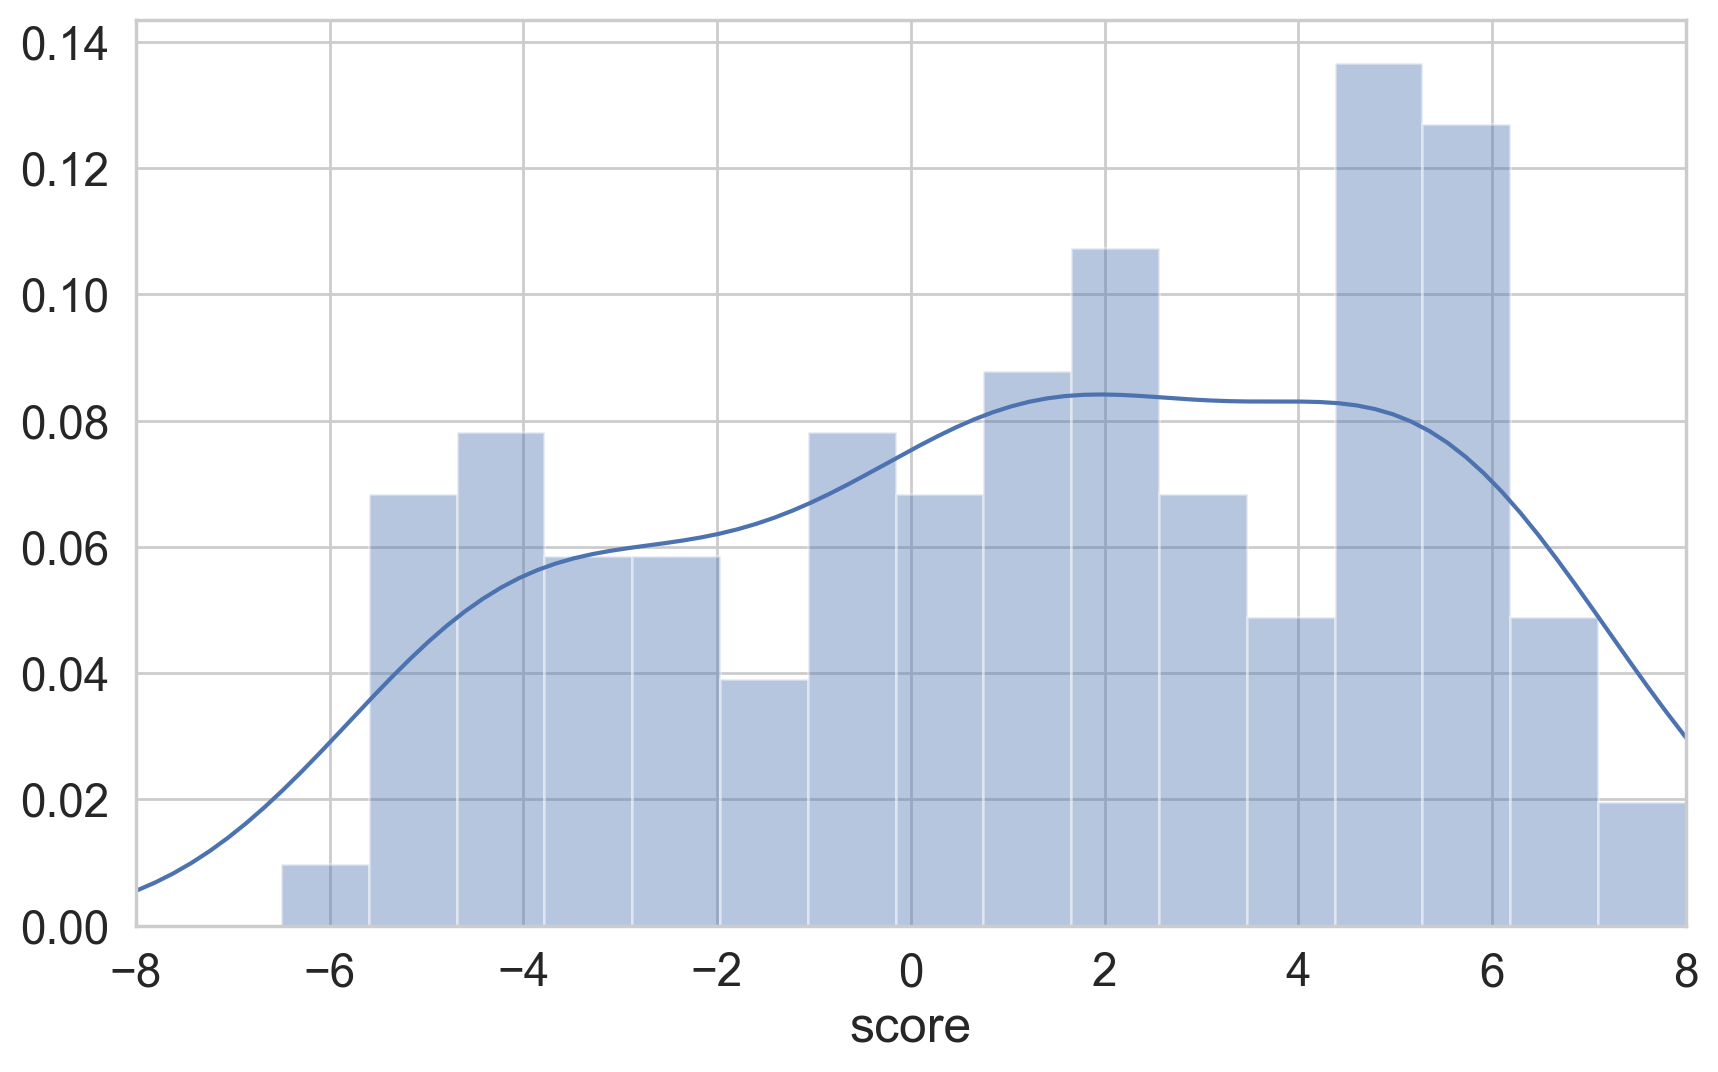

In [15]:
plt.figure(dpi=200, figsize=(10, 6))
sns.distplot(df_scored['score'], bins=16)
plt.xlim(-8, 8);

In [16]:
df_gov = (df_scored[['government', 'score']]
          .groupby('government')
          .agg(['mean', 'std']))
df_protocol = (df_scored[['has_protocol', 'score']]
               .groupby('has_protocol')
               .agg(['mean', 'std']))
df_gov.columns = df_protocol.columns = ['mean', 'std']

In [17]:
df_gov

mean       std
government                    
no          2.090090  3.356998
yes         1.031073  3.983860

In [18]:
df_protocol

mean       std
has_protocol                    
no           -0.160338  3.449415
yes           4.676471  1.961301

<ErrorbarContainer object of 3 artists>

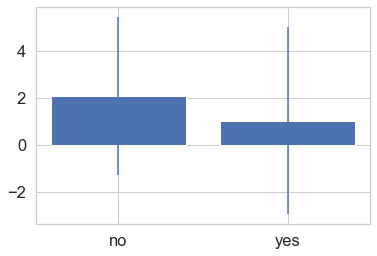

In [19]:
plt.bar(df_gov.index, df_gov['mean'])
plt.errorbar(df_gov.index, df_gov['mean'], yerr=df_gov['std'], fmt='none')

<ErrorbarContainer object of 3 artists>

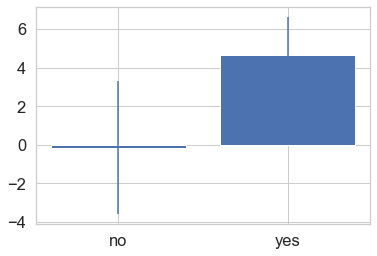

In [20]:
plt.bar(df_protocol.index, df_protocol['mean'])
plt.errorbar(df_protocol.index, df_protocol['mean'], yerr=df_protocol['std'], fmt='none')

In [21]:
(df_scored
 [['has_protocol', 'score']]
 .groupby('has_protocol')
 .agg(['mean', 'std']))

score          
                  mean       std
has_protocol                    
no           -0.160338  3.449415
yes           4.676471  1.961301

In [22]:
pd.crosstab(df_scored['has_protocol'], df_scored['government'])

government    no  yes
has_protocol         
no            24   42
yes           13   17

In [23]:
df_scored[['41_open_source', 'score']].groupby('41_open_source').agg('mean')

score
41_open_source          
-1             -0.705314
 0              4.500000
 1              4.428571

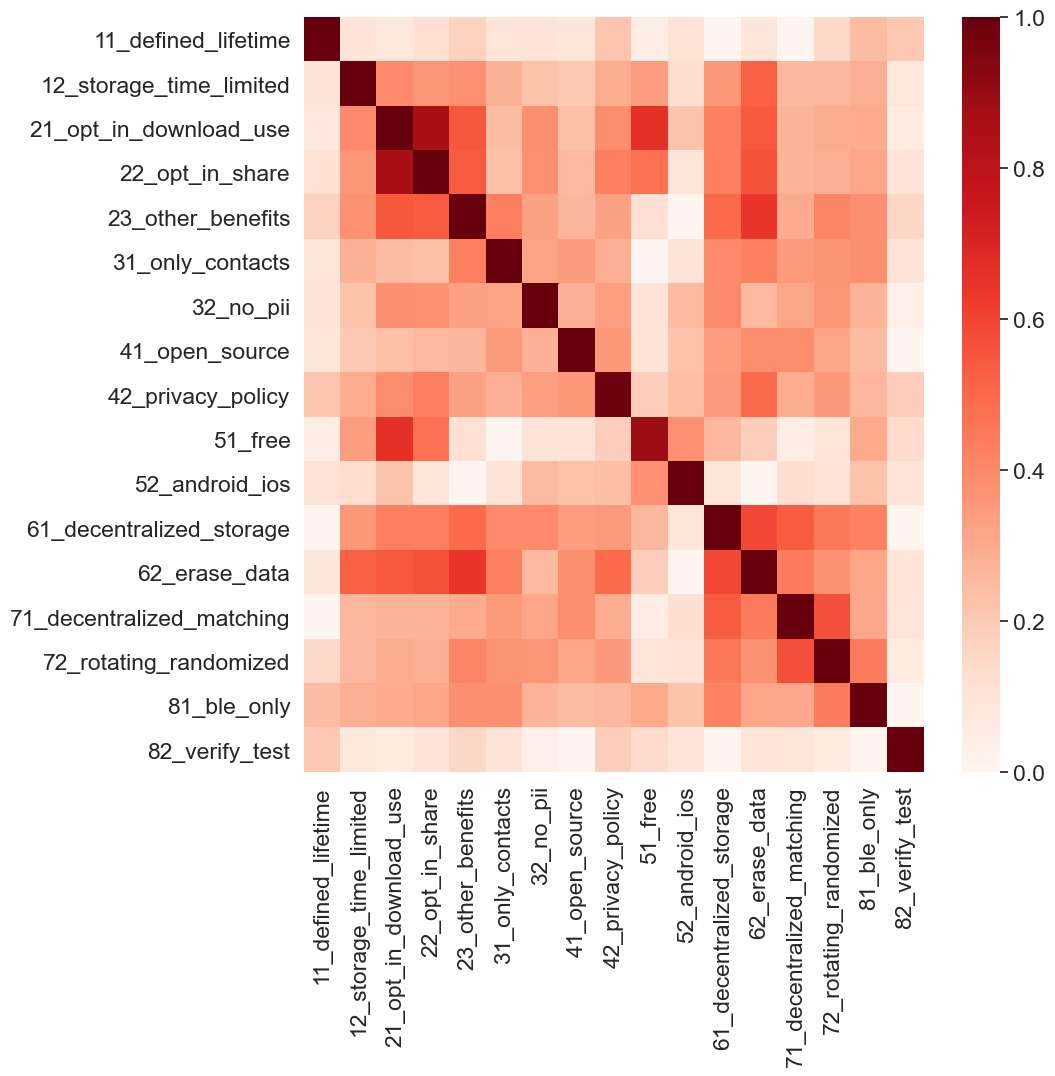

In [24]:
# Association between variables
feature_cols = list(question2col.values())
v_stats = np.zeros((len(feature_cols), len(feature_cols)), dtype=np.float32)
for i, c1 in enumerate(feature_cols):
    for j, c2 in enumerate(feature_cols):
        v_stats[i, j] = utils.cramers_v_corrected(df_scored[c1], df_scored[c2])

plt.figure(dpi=100, figsize=(10, 10))
sns.heatmap(v_stats, cmap='Reds')
plt.xticks(ticks=np.arange(len(feature_cols)) + .5, labels=feature_cols, rotation=90);
plt.yticks(ticks=np.arange(len(feature_cols)) + .5, labels=feature_cols, rotation=0);

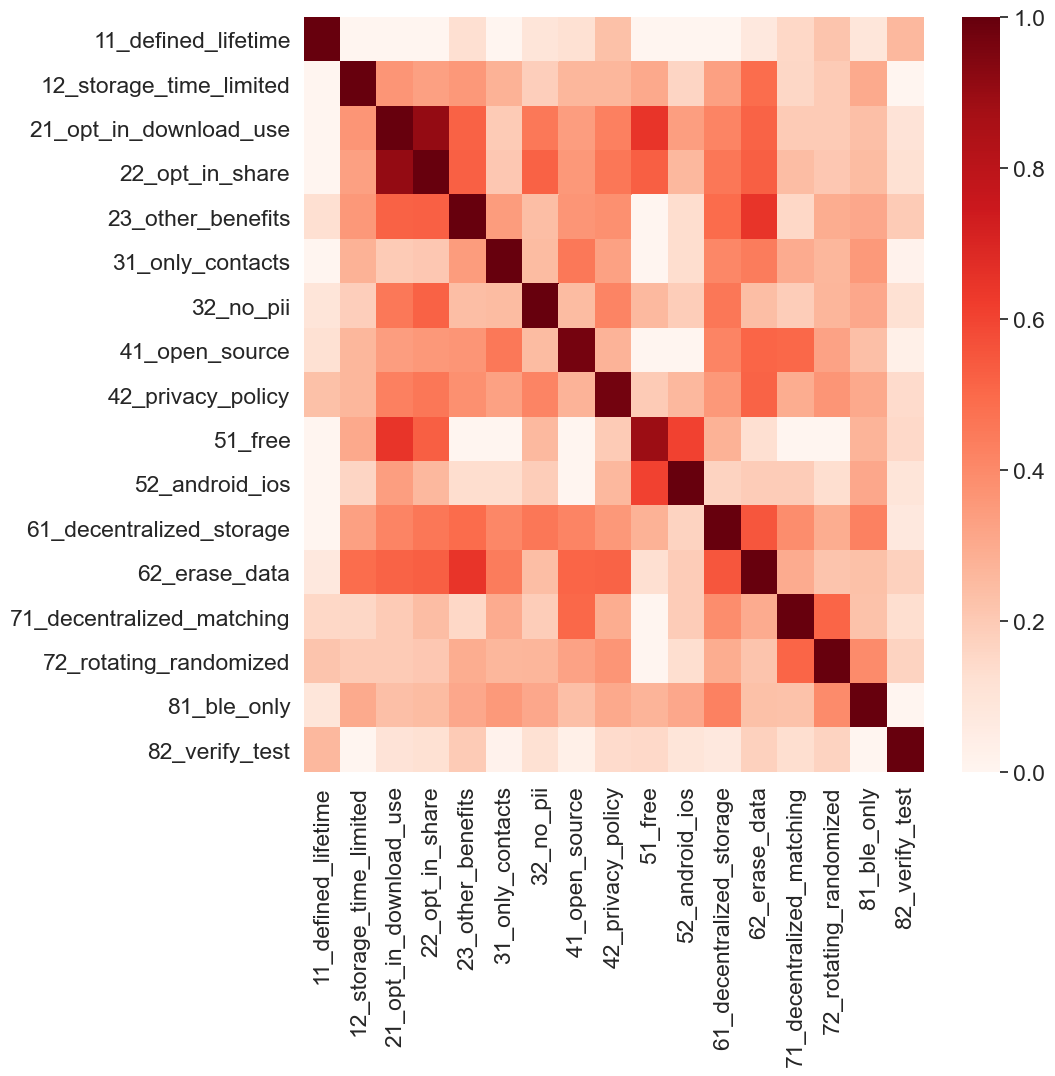

In [25]:
# Association between variables
subset = df_scored.query('has_protocol == "no"')
feature_cols = list(question2col.values())
v_stats = np.zeros((len(feature_cols), len(feature_cols)), dtype=np.float32)
for i, c1 in enumerate(feature_cols):
    for j, c2 in enumerate(feature_cols):
        if np.all(subset[c1] == 1) or np.all(subset[c2] == 1):
            continue
        v_stats[i, j] = utils.cramers_v_corrected(subset[c1], subset[c2])

plt.figure(dpi=100, figsize=(10, 10))
sns.heatmap(v_stats, cmap='Reds')
plt.xticks(ticks=np.arange(len(feature_cols)) + .5, labels=feature_cols, rotation=90);
plt.yticks(ticks=np.arange(len(feature_cols)) + .5, labels=feature_cols, rotation=0);

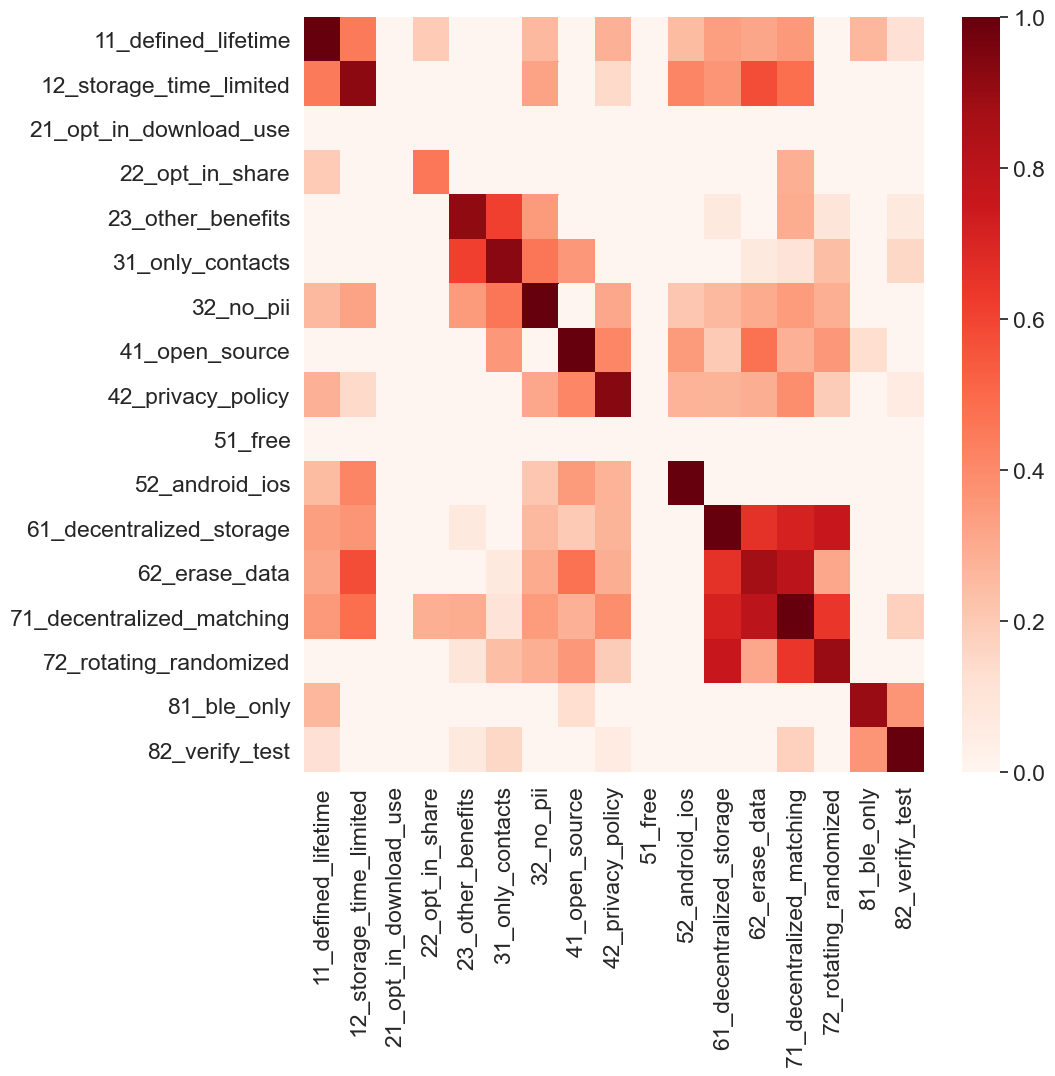

In [26]:
# Association between variables
subset = df_scored.query('has_protocol == "yes"')
feature_cols = list(question2col.values())
v_stats = np.zeros((len(feature_cols), len(feature_cols)), dtype=np.float32)
for i, c1 in enumerate(feature_cols):
    for j, c2 in enumerate(feature_cols):
        if np.all(subset[c1] == 1) or np.all(subset[c2] == 1):
            continue
        v_stats[i, j] = utils.cramers_v_corrected(subset[c1], subset[c2])

plt.figure(dpi=100, figsize=(10, 10))
sns.heatmap(v_stats, cmap='Reds')
plt.xticks(ticks=np.arange(len(feature_cols)) + .5, labels=feature_cols, rotation=90);
plt.yticks(ticks=np.arange(len(feature_cols)) + .5, labels=feature_cols, rotation=0);

Looking at the percentages for each sub-question, broken up by

- Overall
- Government
- Protocol
- Open source
- Country group (choose this)

In [27]:
df_scored[['11_defined_lifetime', 'government']].groupby('government').agg('mean')

11_defined_lifetime
government                     
no                    -0.675676
yes                   -0.457627

In [28]:
data = []
groupcols = ['government', 'has_protocol', '41_open_source']
for col in feature_cols + ['Number of apps', 'Average score']:

    # Total
    question = col if col in ['Number of apps', 'Average score'] else col2question[col]
    row = [question]
    
    if col == 'Number of apps':
        row.append(df_scored.shape[0])
    elif col == 'Average score':
        row.append(df_scored['score'].mean())
    else:
        row.append(np.mean(df_scored[col] == 1))
        question = col2question[col]
    
    for groupcol in groupcols:
        ix = np.logical_or(df_scored[groupcol] == 1, df_scored[groupcol] == 'yes')
        for i in [ix, ~ix]:
            if col == 'Number of apps':
                row.append(np.sum(i))
            elif col == 'Average score':
                row.append(np.mean(df_scored.loc[i, 'score']))
            else:
                row.append(np.mean(df_scored.loc[i, col] == 1))
                    
    data.append(row)

cols = pd.MultiIndex.from_tuples([
    ('Question',''), ('Total',''),
    ('Government', 'yes',), ('Government', 'no'),
    ('Protocol', 'yes'), ('Protocol', 'no'),
    ('Open_source', 'yes'), ('Open_source', 'no')
])
df_question_stats = pd.DataFrame(data, columns=cols).set_index(('Question', ''))
df_question_stats.index.name = 'Question'

/Users/benjaminlevy/Desktop/Benjamin/School/19_20/Classes/spring/ac221/final-project/covid-tracking-env/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [29]:
questions = list(question2col.keys())
lightred = sns.xkcd_palette(['light blue'])[0]
def style_proportion(a, color='light blue'):
    rgb = list(sns.xkcd_palette([color])[0])
    for i in range(len(rgb)):
        rgb[i] = int(rgb[i] * 255)
    r, g, b = rgb
    return f'background-color: rgba({r},{g},{b},{a})'
    
# df_question_stats[('question', '')] = list(col_rename.keys())
(df_question_stats
 .style
 .applymap(style_proportion, subset=pd.IndexSlice[questions, :])
 .format("{:.1%}", subset=pd.IndexSlice[questions, :])
 .format(lambda x: int(x), subset=pd.IndexSlice['Number of apps', :])
 .format("{:.2f}", subset=pd.IndexSlice['Average score', :]))

## Countries

In [30]:
displaydata = df_scored.query('government == "yes"').groupby('Country').agg({'score': ['mean', 'count']})
displaydata.columns = ['mean', 'count']
displaydata = displaydata.sort_values('mean', ascending=True)

In [31]:
displaydata

mean  count
Country                         
Bahrain         -5.000000      1
Qatar           -5.000000      1
Viet Nam        -4.000000      1
Hong Kong       -4.000000      1
China           -4.000000      1
India           -3.619048      7
Kuwait          -3.166667      1
Russia          -3.000000      1
Ghana           -2.333333      1
Philippines     -2.333333      1
Peru            -2.333333      1
South Korea     -1.333333      1
Malaysia        -1.166667      2
Thailand        -0.833333      1
Iran            -0.666667      1
Norway           0.000000      1
Israel           0.000000      1
Saudi Arabia     0.250000      2
Bulgaria         1.166667      1
Indonesia        1.166667      1
Mexico           1.666667      1
Colombia         1.666667      1
Tunisia          1.666667      1
Poland           2.000000      2
Cyprus           2.000000      1
France           2.000000      1
Georgia          2.500000      1
New Zealand      2.666667      1
UAE              2.666667      1
United Kingdom   2.666667      1
Hungary          2.750000      2
Iceland          3.000000      1
North Macedonia  3.000000      1
Jordan           3.166667      1
Canada           4.000000      3
Switzerland      4.500000      1
Australia        5.000000      1
Gibraltar        5.000000      1
Vietname         5.000000      1
Singapore        6.000000      1
Czechia          6.000000      1
United States    6.000000      1
Latvia           7.000000      1
Germany          7.000000      1
Austria          7.000000      1
Morocco          7.000000      1
Italy            8.000000      1

In [32]:
fig = go.Figure()

hovertemplate = '''
<b>%{y}</b><br><br>
Average score: %{x}<br>
Number of apps: %{text}
<extra></extra>
'''

for query, color in zip(['mean < 0', 'mean >= 0'], ['orangered', 'lightblue']):
    subset = displaydata.query(query)
    fig.add_trace(
        go.Bar(
            x=subset['mean'],
            y=subset.index,
            text=subset['count'],
            orientation='h',
            hovertemplate=hovertemplate,
            marker_color=color,
            showlegend=False
        )
    )
    
fig.update_layout(
    xaxis={'title':'Average score'},
    title="Average country score for government-backed apps",
    width=1000,
    height=600
)

fig.show()

In [33]:
py.plot(fig, filename='avg_country_score', auto_open=True)

'https://plotly.com/~benjaminlevy/3/'

## Time series

In [34]:
# Converting into a list where each element is a unique date with all the apps that existed on that date
start_date = date(2020, 2, 1) # February 1, 2020
end_date = date(2020, 7, 1) # July 1, 2020

days = {}
curr = start_date
while curr <= end_date:
    days[curr] = []
    curr += timedelta(days=1)

In [35]:
statuses = ['proposed', 'dev', 'released', 'cancelled']
for idx, row in df_scored.iterrows():
    dct = row.to_dict()
    app_statuses = []
    for status in statuses:
        status_date = dct[f'date_{status}']
        if not pd.isna(status_date):
            d = date(*[int(i) for i in status_date.split('-')])
            app_statuses.append((status, d))
    app_statuses.append(('end', end_date + timedelta(days=1)))
    
    for i in range(len(app_statuses) - 1):
        dct_cp = dct.copy()
        s, d0 = app_statuses[i]
        _, d1 = app_statuses[i + 1]
        dct_cp['status'] = s
        curr = d0
        while curr < d1:
            li = days[curr]
            li.append(dct_cp)
            days[curr] = li
            curr += timedelta(days=1)

In [36]:
def plot_time_series(groupvar, unknown=None, status=None, stacked=True, return_data=False):
    data = []
    for d, apps in days.items():
        row = {'date': d}
        for app in apps:
            if status is not None:
                if type(status) not in [list, tuple]:
                    status = [status]
                if app['status'] not in status:
                    continue
            level = app[groupvar]
            if unknown is not None or unknown == 'show':
                if level == 'unknown':
                    if unknown in ['drop', 'hide']:
                        continue
                    else:
                        level = unknown
            currval = row.get(level, 0)
            currval += 1
            row[level] = currval
        data.append(row)
    df_time = pd.DataFrame(data).fillna(0)
    if return_data:
        return df_time
    
    plt.figure(figsize=(16, 6), dpi=200)
    y0 = np.zeros(len(df_time))
    x = df_time['date']
    for level in np.sort(df_time.columns[1:]):
        y1 = df_time[level]
        plt.fill_between(x, y0, y1 + y0, label=level, alpha=0.4)
        if stacked:
            y0 += y1
    plt.legend(loc='upper left')
    if stacked:
        ymax = max(y0)
        plt.ylim(0, ymax)
    plt.xlim(start_date, end_date)
    plt.title(groupvar)
    plt.grid(b=None)
    ax = plt.gca()
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
        

def plot_score_time_series(status=None, stacked=False):
    data = []
    for d, apps in days.items():
        row = {'date': d}
        day_total_score = 0.
        day_count = 0.
        for app in apps:
            if status is not None:
                if type(status) not in [list, tuple]:
                    status = [status]
                if app['status'] not in status:
                    continue
            day_total_score += app['score']
            day_count += 1.
        row['avg_score'] = day_total_score / day_count if day_count > 0 else 0
        data.append(row)
    df_time = pd.DataFrame(data).fillna(0)

    plt.figure(figsize=(16, 6), dpi=200)
    y0 = np.zeros(len(df_time))
    x = df_time['date']
    for level in np.sort(df_time.columns[1:]):
        y1 = df_time['avg_score']
        plt.fill_between(x, y0, y1 + y0, label=level, alpha=0.4)
        if stacked:
            y0 += y1
    plt.legend(loc='upper left')
    if stacked:
        ymax = max(y0)
        plt.ylim(0, ymax)
    plt.xlim(start_date, end_date)
    plt.title("Score over time")
    plt.grid(b=None)
    ax = plt.gca()
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
        

In [37]:
displaydata = plot_time_series('has_protocol', status=['released', 'dev'],
                               stacked=True, unknown='drop', return_data=True)

fig = go.Figure()


for status, level, color in zip(['yes', 'no'], ["With protocol", "No protocol"], ['lightblue', 'orangered']):
    hovertemplate = level + ": %{y}<extra></extra>"
    fig.add_trace(go.Scatter(
        x=displaydata['date'],
        y=displaydata[status],
        mode='lines',
        hovertemplate=hovertemplate,
        line=dict(width=0.5, color=color),
        stackgroup='one',
        name=level
    ))
fig.update_layout(hovermode='x', 
                  yaxis={'title': "Number of apps"},
                  xaxis={'title': "Date"},
                  title="Apps released or in development with privacy-preserving protocol")
fig.show()

py.plot(fig, filename='protocol_time_series', auto_open=True)

'https://plotly.com/~benjaminlevy/5/'

In [38]:
displaydata = plot_time_series('41_open_source', status=['released', 'dev'],
                               stacked=True, unknown='drop', return_data=True)

fig = go.Figure()


for status, level, color in zip([1, -1, 0],
                                ["Open source", "Closed source", "Unknown"],
                                ['lightblue', 'orangered', 'gray']):
    hovertemplate = str(level) + ": %{y}<extra></extra>"
    fig.add_trace(go.Scatter(
        x=displaydata['date'],
        y=displaydata[status],
        mode='lines',
        hovertemplate=hovertemplate,
        line=dict(width=0.5, color=color),
        stackgroup='one',
        name=level
    ))
fig.update_layout(hovermode='x', 
                  yaxis={'title': "Number of apps"},
                  xaxis={'title': "Date"},
                  title="Open or closed-source apps released or in development")
fig.show()

py.plot(fig, filename='open_source_time_series', auto_open=True)

'https://plotly.com/~benjaminlevy/7/'

In [39]:
# TODO: Make this in plotly!
null_flag = ~pd.isna(df_scored['date_released'])
displaydata = df_scored.loc[null_flag, ['Name', 'Country', 'date_released', 'score']].sort_values('date_released')
dates = pd.to_datetime(displaydata['date_released'])
firstdate = min(dates)
x = (dates - firstdate).apply(lambda x: x.days)
y = displaydata['score']

hovertemplate = '''
<b>%{text}</b><br><br>
Score: %{y}<br>
Date released: %{x}
<extra></extra>
'''

fig = go.Figure(data=go.Scatter(x=dates, y=y, mode='markers',
                                hovertemplate=hovertemplate,
                                text=displaydata.apply(lambda row: f'{row["Name"]} ({row["Country"]})', axis=1),
                                showlegend=False))
# fig = px.scatter(displaydata, x='date_released', y='score')

# # Linear model
slope, intercept, r, p, std = sps.linregress(x, y)
xx = np.linspace(0, max(x))
tt = [firstdate + timedelta(days=xi) for xi in xx]
# plt.plot(xx, xx * slope + intercept, label='Simple linear regression')
fig.add_trace(go.Scatter(x=tt, y=xx * slope + intercept, 
                         mode='lines', name='Regression line',
                         text=f'Score = {intercept:.1f} + {slope:.2f}(date)',
                         line_color='lightblue', hoverinfo='none'))

fig.update_layout(
    xaxis={'title':'Date'},
    yaxis={'title':'App score'},
    title="App score by release date"
)

fig.show()

In [41]:
py.plot(fig, filename='app_score_release_date', auto_open=True)

'https://plotly.com/~benjaminlevy/12/'